In [183]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from rich import print as pprint
from IPython.display import display, Markdown
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
import random
import pygad

In [184]:
TERMS_N = 5
STEPS_N = 10
POPULATION_SIZE = 10

In [185]:
class Bounds:
    def __init__(self, left, right):
        self.left = left
        self.right = right

X_BOUNDS = Bounds(-5., 5.)
Y_BOUNDS = Bounds(-5., 5.)
Z_BOUNDS = Bounds(-1., 1.)

PI = 3.1415926535897932384626433832795

def F(x, y):
    return np.sin(2*x/PI) * np.sin(2*y/PI)

In [186]:
#input
def abcs_from_points(points):
    n = len(points)
    abcs = [points[0], points[0], points[1]]
    for i in range(1, n-1):
        abcs.extend([points[i-1], points[i], points[i+1]])
    abcs.extend([points[-2], points[-1], points[-1]])
    return abcs

def uniform_distr(a, b, n):
    points = np.linspace(a, b, n)
    return abcs_from_points(points)

def random_distr(a, b, n):
    points = [a]
    for _ in range(n-2):
        points.append(random.uniform(a, b))
    points.append(b)
    points.sort()
    return abcs_from_points(points)

input_population = []
uniform = []
uniform.extend(uniform_distr(X_BOUNDS.left, X_BOUNDS.right, TERMS_N))
uniform.extend(uniform_distr(Y_BOUNDS.left, Y_BOUNDS.right, TERMS_N))
uniform.extend(uniform_distr(Z_BOUNDS.left, Z_BOUNDS.right, TERMS_N))
input_population.append(np.array(uniform))
for i in range(POPULATION_SIZE-1):
    v = []
    v.extend(random_distr(X_BOUNDS.left, X_BOUNDS.right, TERMS_N))
    v.extend(random_distr(Y_BOUNDS.left, Y_BOUNDS.right, TERMS_N))
    v.extend(random_distr(Z_BOUNDS.left, Z_BOUNDS.right, TERMS_N))
    input_population.append(np.array(v))
input_population = np.array(input_population)

In [187]:
# validation
def group_by_n(a, n):
    b = []
    for i in range(0, len(a), n):
        b.append(a[i:i+n])
    return b

def is_valids(a):
    xs = group_by_n(a[:TERMS_N*3], 3)
    ys = group_by_n(a[TERMS_N*3:TERMS_N*3*2], 3)
    zs = group_by_n(a[TERMS_N*3*2:TERMS_N*3*3], 3)
    return is_valid(xs) and is_valid(ys) and is_valid(zs)

def is_valid(a):
    for v in a:
        if v[0] > v[1] or v[1] > v[2]:
            return False
    for i in range(1, len(a)):
        if a[i-1][1] > a[i][1]:
            return False
        if a[i-1][2] < a[i][0]:
            return False
    
    return True

for v in input_population:
    assert(is_valids(v))

In [188]:
# fitness
def find_term(universe, antecedent, v):
    max_deg = 0
    max_term = ''
    for term in antecedent.terms:
        deg = fuzz.fuzzymath.interp_membership(
            universe, 
            antecedent[term].mf, 
            v
        )
        if deg <= max_deg:
            continue
        max_deg = deg
        max_term = term
    return max_term

def generate_rules(x_abcs, y_abcs, xv, yv, zv):
    rules_dict = {}
    for x_abc in x_abcs:
        x_value = x_abc[1]
        x_term = find_term(xv.universe, xv, x_value)
        for y_abc in y_abcs:
            y_value = y_abc[1]
            y_term = find_term(yv.universe, yv, y_value)
            z_value = F(x_value, y_value)
            z_term = find_term(zv.universe, zv, z_value)
            rules_dict[(x_term, y_term)] = z_term
    rules = []
    for x_term, y_term in rules_dict:
        z_term = rules_dict[(x_term, y_term)]
        rule = ctrl.Rule(antecedent=(xv[x_term] & yv[y_term]),
                        consequent=zv[z_term])
        rules.append(rule)
    return rules

def simulation_error_metric(sim, obs_n):
    observations = []
    obs_zs = []
    real_zs = []
    for xi in np.linspace(X_BOUNDS.left, X_BOUNDS.right, obs_n):
        for yi in np.linspace(Y_BOUNDS.left, Y_BOUNDS.right, obs_n):
            sim.input['x'] = xi
            sim.input['y'] = yi
            sim.compute()
            obs_z = sim.output['z']
            real_z = F(xi, yi)
            observations.append([xi, yi, obs_z])
            obs_zs.append(obs_z)
            real_zs.append(real_z)
    mse = mean_squared_error(real_zs, obs_zs)
    return mse

def fitness_func(solution, solution_idx):
    step = 0.25
    x_universe = np.arange(X_BOUNDS.left, X_BOUNDS.right+2*step, step)
    y_universe = np.arange(Y_BOUNDS.left, Y_BOUNDS.right+2*step, step)
    z_universe = np.arange(Z_BOUNDS.left, Z_BOUNDS.right+2*step, step)

    xv = ctrl.Antecedent(x_universe, 'x')
    yv = ctrl.Antecedent(y_universe, 'y')
    zv = ctrl.Consequent(z_universe, 'z')

    x_abcs = group_by_n(solution[0: TERMS_N*3], 3)
    y_abcs = group_by_n(solution[TERMS_N*3: TERMS_N*3*2], 3)
    z_abcs = group_by_n(solution[TERMS_N*3*2: TERMS_N*3*3], 3)

    for i in range(TERMS_N):
        xv[f"{i+1}"] = fuzz.trimf(xv.universe, x_abcs[i])
        yv[f"{i+1}"] = fuzz.trimf(yv.universe, y_abcs[i])
        zv[f"{i+1}"] = fuzz.trimf(zv.universe, z_abcs[i])

    rules = generate_rules(x_abcs, y_abcs, xv, yv, zv)

    system = ctrl.ControlSystem(rules=rules)
    sim = ctrl.ControlSystemSimulation(system)

    obs_n = 4
    err_metric = simulation_error_metric(sim, obs_n)
    return 1.0 / err_metric



In [189]:
# crossover
def crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
        while True:
            random_split_point = np.random.choice(range(offspring_size[0]))
            a = np.append(parent1[:random_split_point], parent2[random_split_point:])
            if is_valids(a):
                offspring.append(a)
                break
        idx += 1

    return np.array(offspring)

In [190]:
# mutation
def mutation_func(offspring, ga_instance):
    for chromosome_id in range(offspring.shape[0]):
        while True:
            gene_id = random.randint(0, offspring.shape[1]-1)
            if gene_id in [0, 1,  TERMS_N*3-2, TERMS_N*3-1,
                TERMS_N*3, TERMS_N*3+1, TERMS_N*3*2-2, TERMS_N*3*2-1, 
                TERMS_N*3*3, TERMS_N*3*3+1, TERMS_N*3*4-2, TERMS_N*4-1]:
                continue
            r = 0.1
            chromosome = offspring[chromosome_id]
            chromosome[gene_id] += r
            if is_valids(chromosome):
                offspring[chromosome_id] = chromosome
                break
            chromosome[gene_id] -= r
    return offspring

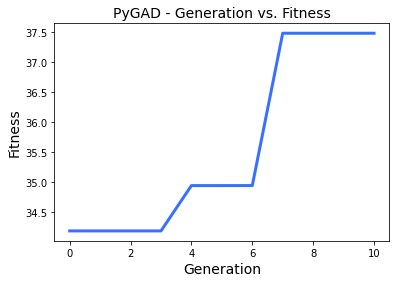

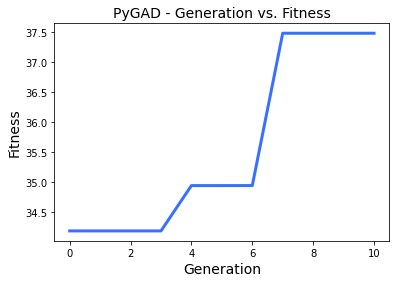

In [191]:
ga_instance = pygad.GA(
    num_generations=STEPS_N,
    fitness_func= fitness_func,
    initial_population=input_population,
    #parent_selection_type="tournament",
    crossover_type=crossover_func,
    mutation_type=mutation_func,
    num_parents_mating=4,
)
ga_instance.run()
ga_instance.plot_fitness()